imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import pickle


meta data

In [34]:
df = pd.read_csv("C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


distribuição das classes

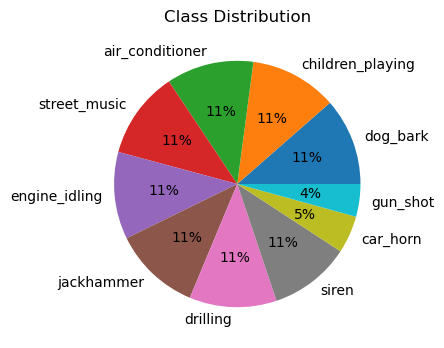

In [31]:
df['class'].value_counts().plot(kind='pie', autopct='%1.0f%%', figsize=(4,4))
plt.title('Class Distribution')
plt.ylabel('')
plt.show()

feature extraction and pre-processing

Padding of the Audio to a Fixed Length

In [37]:
import os

def padding(path, duration = 4, sr = 22050, files_limit = 1, verbose = False):
    files = librosa.util.find_files(path)
    data = []

    for index, file_path in enumerate(files):
        if files_limit != -1 and index >= files_limit:
            break
        if verbose:
            print(f"Processing audio {index + 1}/{len(files)}")
        try:
            audio, _ = librosa.load(file_path, sr=sr, mono=True)

            audio = np.pad(audio, (0, max(0, duration*sr - len(audio))), mode='constant')
            audio = audio[:duration * sr]

            file_name = os.path.basename(file_path)
            data.append([file_name, audio])
        
        except Exception:
            print(f"Error in processig file {file_path}: {Exception}")

    return data

            


feature extraction

In [46]:
def feature_extraction(dataframe, audios, hop_length = 256, n_fft = 1024, sr = 22050):
    log_spectograms = []
    labels = []

    for index in range(len(audios)):
        try:
            file_name =audios[index][0]
            if file_name:
                row = dataframe.loc[dataframe["slice_file_name"] == file_name]

                if not row.empty:
                    label = row.iloc[0,6]
                    spectogram = np.abs(librosa.core.stft(
                        y = np.array(audios[index][1]),
                        hop_length = hop_length,
                        n_fft = n_fft
                    ))
                    log_spectogram = librosa.amplitude_to_db(spectogram)
                    log_spectograms.append(log_spectogram)
                    labels.append(label)
        except Exception:
            print(f"Error in processig file {audios[index][0]}: {Exception}")

    log_spectograms = np.array(log_spectograms)
    labels = np.array(labels)
    return log_spectograms, labels

data normalization and pre-processing

In [48]:
fold_paths = ["C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold1",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold2",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold3",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold4",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold5",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold6",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold7",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold8",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold9",
              "C:/Users/guica/OneDrive/Documentos/UrbanSound8K/UrbanSound8K/audio/fold10"]

In [54]:
features = []
label = []

for i, fold in enumerate(fold_paths):
    print(f"Processing Folder Number {i+1}")
    audio_data = padding(fold)
    log_spectograms, labels = feature_extraction(df, audio_data)
    log_spectograms_normalized = (log_spectograms - np.mean(log_spectograms)) / np.std(log_spectograms)
    encoded_labels = np.zeros((len(labels), 10))
    encoded_labels[np.arange(len(labels)), labels] = 1
    features.append(log_spectograms_normalized)
    print(f"Fold {i+1} Features: {features}")
    label.append(encoded_labels)
    print(f"Fold {i+1} Label: {label}")



# Combine all folds (ensure shapes match)
features = np.concatenate(features, axis=0)
label = np.concatenate(label, axis=0)

Processing Folder Number 1
Fold 1 Features: [array([[[ 0.22004575,  0.06683294, -0.424995  , ..., -0.424995  ,
          0.10073089,  1.9570735 ],
        [ 0.11848179, -0.0293848 , -0.424995  , ..., -0.04207647,
          0.877518  ,  1.9875695 ],
        [-0.05188299, -0.12261391, -0.340742  , ...,  0.7991769 ,
          1.0000358 ,  1.7282538 ],
        ...,
        [-0.424995  , -0.424995  , -0.424995  , ..., -0.424995  ,
         -0.424995  , -0.05322096],
        [-0.424995  , -0.424995  , -0.424995  , ..., -0.424995  ,
         -0.424995  , -0.05380441],
        [-0.424995  , -0.424995  , -0.424995  , ..., -0.424995  ,
         -0.424995  , -0.05399361]]], dtype=float32)]
Fold 1 Label: [array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])]
Processing Folder Number 2
Fold 2 Features: [array([[[ 0.22004575,  0.06683294, -0.424995  , ..., -0.424995  ,
          0.10073089,  1.9570735 ],
        [ 0.11848179, -0.0293848 , -0.424995  , ..., -0.04207647,
          0.877518  ,  1.9875695 

### Model Architecture

#### 1. Input Layer
- Shape: (x, y) where:
  - x is the number of timesteps (sequence length).
  - y is the number of features per timestep (e.g., MFCC coefficients).
- Purpose: The model expects a sequential input where each timestep represents a feature vector of the audio signal.
#### 2. First Bidirectional LSTM Layer
Description: A Bidirectional LSTM with 128 units.
- Bidirectionality: Processes the sequence in both forward and backward directions to capture dependencies in the audio signal from past and future timesteps.
- Activation: tanh for non-linearity.
- Kernel Initialization: glorot_uniform for balanced weight initialization.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Randomly drops 30% of connections to prevent overfitting.</b>
- Batch Normalization: <b>Normalizes the output of the LSTM layer, ensuring stability during training by keeping activations in a consistent range.</b>

#### 3. Second Bidirectional LSTM Layer
Description: Another Bidirectional LSTM with 128 units.
- Purpose: Further refines temporal features extracted from the first LSTM layer, learning more complex patterns.
- Output: Produces a sequence of 128 features for each timestep.
- Dropout (0.3): <b>Again, drops 30% of connections for regularization.</b>
- Batch Normalization: <b>Stabilizes activations and accelerates convergence.</b>

#### 4. TimeDistributed Dense Layers
Description: Fully connected layers applied independently to each timestep. These layers transform the feature representation at each timestep into higher-level abstractions.
- First Dense Layer:
  - Units: 128 neurons.
  - Activation: ReLU for faster training and reduced vanishing gradient issues.
  - Regularization: L2 regularization (0.01) to prevent overfitting.
  - Dropout (0.2): Drops 20% of connections.
- Second Dense Layer:
  - Units: 64 neurons.
  - Activation: ReLU.
  - Regularization: L2 regularization (0.01).
  - Dropout (0.2).
  - Purpose: These layers learn high-level feature transformations for each timestep.

#### 5. Flatten Layer
Description: Flattens the outputs of the TimeDistributed Dense layers into a single vector.
- Purpose: Converts the 2D sequence of features into a 1D vector suitable for final classification.

#### 6. Output Layer
Description: A fully connected Dense layer with 10 neurons.
- Activation: Softmax, which outputs a probability distribution over the 10 sound classes.
- Purpose: Final classification into one of the 10 categories.

In [ ]:
from tensorflow.keras import Sequential, regularizers, layers
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed, Flatten, BatchNormalization

def create_bidirectional_model(x, y):
    input_shape = (x, y)  # Shape of X_train sample

    model = Sequential()

    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'), input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=True, activation='tanh')))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # TimeDistributed Dense layers
    model.add(TimeDistributed(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
    model.add(Dropout(0.2))

    # Flatten layer
    model.add(Flatten())

    # Fully connected output layer
    model.add(Dense(10, activation='softmax'))

    return model


In [2]:
model = create_bidirectional_model(129, 173)
model.summary()

c:\Users\joaob\Documents\GitHub\Sound_Classification\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 129, 256)       │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 129, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 129, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 129, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 129, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 129, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 129, 128)       │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 129, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 129, 64)        │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 129, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8256)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        82,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 829,258 (3.16 MB)

 Trainable params: 828,234 (3.16 MB)

 Non-trainable params: 1,024 (4.00 KB)

training strategies

performance evaluation